In [ ]:
INPUT Shape= 180*180 
CUSTOME MADE DataSet

In [2]:
# Importing Tools & Libraries

import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import  Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, f1_score, PrecisionRecallDisplay

from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

from tensorflow.keras.metrics import Precision, Recall
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

In [3]:
# Loading Dataset and Define the Path
data_dir = '/kaggle/input/project/DataSet_5(Final)'


In [4]:
# Data Splitting in Validation & Test for training   also applying Data augmentation  

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=(0.7, 1.5),
    horizontal_flip=True,
    validation_split=0.2  # Use 20% of the data for validation+test
)

In [5]:
# Data augmentation is not applied to validation and test data

test_val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.5   # Splitting validation + test into 50% validation, 50% test
)

In [6]:
# Training data generator
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

Found 4669 images belonging to 7 classes.


In [7]:
# Validation data generator
val_generator = test_val_datagen.flow_from_directory(
    data_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 2915 images belonging to 7 classes.


In [8]:
# Test data generator
test_generator = test_val_datagen.flow_from_directory(
    data_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

Found 2918 images belonging to 7 classes.


In [9]:
# Confirmation split Samples

print(f"Training samples: {len(train_generator.filenames)}")
print(f"Validation samples: {len(val_generator.filenames)}")
print(f"Test samples: {len(test_generator.filenames)}")

Training samples: 4669
Validation samples: 2915
Test samples: 2918


In [10]:
# Loading vgg16 model Also Fine-Tuning the Fully-connected Layer

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(460, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(56, activation='relu')(x)
x = Dense(188, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False
    # Define the optimizer with a custom learning rate
    custom_learning_rate = 0.0003102
    optimizer = Adam(learning_rate=custom_learning_rate)

In [11]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 460)            │     5,888,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 460)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 56)             │        25,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 188)            │        10,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,32

 Total params: 20,641,003 (78.74 MB)

 Trainable params: 5,926,315 (22.61 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
history_vgg16 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size,
    epochs=20
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/145 ━━━━━━━━━━━━━━━━━━━━ 1:06:57 28s/step - accuracy: 0.0625 - loss: 2.2361

I0000 00:00:1718748794.195925     409 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718748794.218194     409 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


121/145 ━━━━━━━━━━━━━━━━━━━━ 13s 569ms/step - accuracy: 0.4334 - loss: 1.5245

W0000 00:00:1718748862.481856     409 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.4547 - loss: 1.4694

W0000 00:00:1718748870.460778     411 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


145/145 ━━━━━━━━━━━━━━━━━━━━ 113s 588ms/step - accuracy: 0.4554 - loss: 1.4673 - val_accuracy: 0.7630 - val_loss: 0.6406
Epoch 2/20
  1/145 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.4688 - loss: 1.3488

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.4688 - loss: 1.3488 - val_accuracy: 0.6667 - val_loss: 0.5300
Epoch 3/20


W0000 00:00:1718748884.039735     411 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


145/145 ━━━━━━━━━━━━━━━━━━━━ 54s 355ms/step - accuracy: 0.6660 - loss: 0.8972 - val_accuracy: 0.8163 - val_loss: 0.5217
Epoch 4/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step - accuracy: 0.7500 - loss: 0.5245 - val_accuracy: 0.6667 - val_loss: 0.4361
Epoch 5/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 54s 357ms/step - accuracy: 0.7106 - loss: 0.7799 - val_accuracy: 0.8541 - val_loss: 0.4140
Epoch 6/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step - accuracy: 0.8125 - loss: 0.4865 - val_accuracy: 0.6667 - val_loss: 0.7785
Epoch 7/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 54s 359ms/step - accuracy: 0.7444 - loss: 0.7014 - val_accuracy: 0.8482 - val_loss: 0.4375
Epoch 8/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - accuracy: 0.8750 - loss: 0.4501 - val_accuracy: 0.3333 - val_loss: 0.7734
Epoch 9/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 54s 358ms/step - accuracy: 0.7463 - loss: 0.6845 - val_accuracy: 0.8468 - val_loss: 0.4391
Epoch 10/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step - accuracy: 0.7188 - loss: 0.8061 - val_ac

In [17]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // test_generator.batch_size)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - accuracy: 0.8619 - loss: 0.4118
Test loss: 0.4243411421775818
Test accuracy: 0.848901093006134


In [18]:
def plot_history(history, title):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{title} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{title} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()
    
    


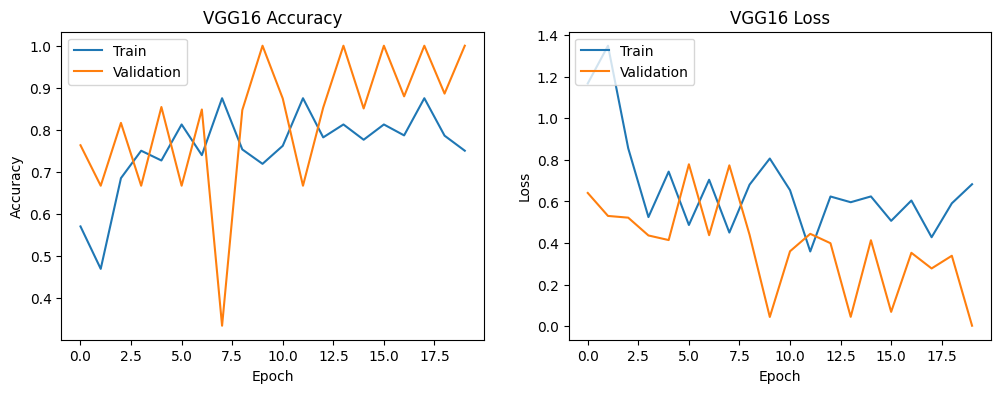

In [19]:
# Plot history for VGG16
plot_history(history_vgg16,'VGG16')

In [20]:
# Printing Classification Report

test_generator.reset()
preds = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

 3/92 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step  

W0000 00:00:1718749381.118670     411 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 174ms/step
                 precision    recall  f1-score   support

        Dolphin       0.11      0.10      0.11       391
     Jelly Fish       0.17      0.14      0.16       423
        Octopus       0.09      0.11      0.10       281
    Sea Urchins       0.09      0.09      0.09       290
         Sharks       0.08      0.07      0.07       295
Turtle_Tortoise       0.33      0.34      0.34       952
          Whale       0.09      0.10      0.09       286

       accuracy                           0.18      2918
      macro avg       0.14      0.14      0.14      2918
   weighted avg       0.18      0.18      0.18      2918



W0000 00:00:1718749396.989943     408 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


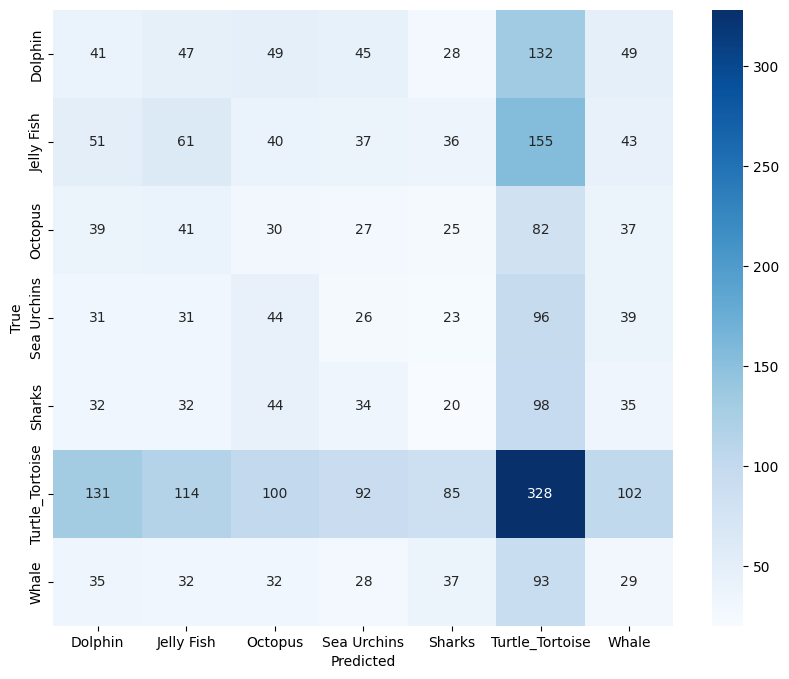

In [21]:
# Plotting Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [22]:
# Printing precision, Recall, F1 score

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.18264469215367665
Recall: 0.18334475668265934
F1 Score: 0.1826026949890762


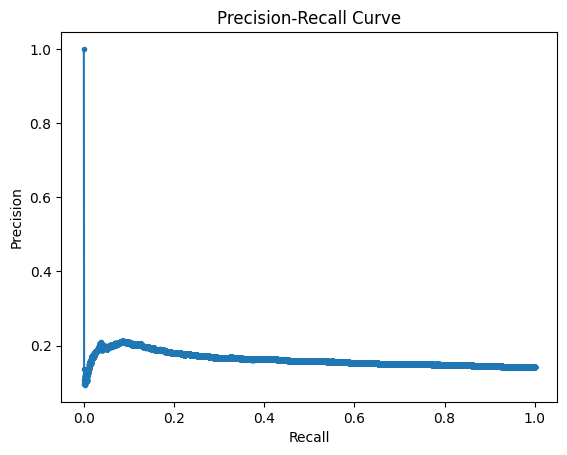

In [23]:
# Plot precision-recall curve
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Binarize the output for precision-recall curve
y_test_bin = label_binarize(y_true, classes=list(test_generator.class_indices.values()))
y_score_bin = preds

precision_curve, recall_curve, _ = precision_recall_curve(y_test_bin.ravel(), y_score_bin.ravel())

plt.figure()
plt.plot(recall_curve, precision_curve, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [24]:
# Save the VGG16 model
model.save('Vgg16_CDS5(84.89%).h5')